In [2]:
import json
import glob
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd

In [4]:
from collections import Counter,OrderedDict

In [5]:
def represent_odict(dumper, instance):
     return dumper.represent_mapping(u'tag:yaml.org,2002:map', instance.items())

yaml.add_representer(OrderedDict, represent_odict)

def construct_odict(loader, node):
    return OrderedDict(loader.construct_pairs(node))

yaml.add_constructor(u'tag:yaml.org,2002:map', construct_odict)

In [6]:
def ea(domain="DCM",threshold=0.5):
    results = {
        'O':{'O':[],'T':[],'X':[]},
        'T':{'O':[],'T':[],'X':[]},
        'X':{'O':[],'T':[],'X':[]}
    }
    ref_paths = glob.glob("../DBDC2_ref/"+domain+"/*.json")
    pred_paths = glob.glob("./result/"+domain+"/*.json")

    refs = [json.load(open(ref)) for ref in ref_paths]
    preds = [json.load(open(ref)) for ref in pred_paths]

    refs = sorted(refs,key = lambda x: x['dialogue-id'])
    preds = sorted(preds,key = lambda x: x['dialogue-id'])

    for ref,pred in zip(refs,preds):
        #print("------------dialogue-id :",ref['dialogue-id'],"------------")
        for i in range(0,len(ref['turns']),2):
            labels = ("O","T","X")
            user = "" if i == 0 else ref['turns'][i-1]['utterance']
            system = ref['turns'][i]['utterance']
            pred_dict = pred['turns'][int(i/2)]['labels'][0]

            breakdown_pred = pred_dict['breakdown']
            dist_pred = [pred_dict['prob-O'],pred_dict['prob-T'],pred_dict['prob-X']]
            dist_pred = list(map(float,dist_pred))
            dist_pred = [round(x,2) for x in dist_pred]
            annts_all = ref['turns'][i]['annotations']
            annts = [elem['breakdown'] for elem in annts_all]
            count = Counter(annts)
            dist_ref = np.array([count[label] for label in labels])
            dist_ref = dist_ref / np.sum(dist_ref)

            prob_O,prob_T,prob_X = dist_ref

            if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
                breakdown_ref = "O"
            elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
                breakdown_ref =  "T"
            elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
                breakdown_ref =  "X"
            else:
                breakdown_ref =  "O"
            dist_ref = [round(float(x),2) for x in dist_ref]
            
            
            internal_result = OrderedDict([
                ('dialogue-id',ref['dialogue-id']),
                ('turn',i),
                ('user',user),
                ('system',system),
                ('reference_proba', dist_ref),
                ('predict_proba',dist_pred),
                
            ])
            results[breakdown_ref][breakdown_pred].append(internal_result)
    return results

In [7]:
def ea_df(domain="DCM",threshold=0.5):
    results = []
    ref_paths = glob.glob("../DBDC2_ref/"+domain+"/*.json")
    pred_paths = glob.glob("./result/"+domain+"/*.json")

    refs = [json.load(open(ref)) for ref in ref_paths]
    preds = [json.load(open(ref)) for ref in pred_paths]

    refs = sorted(refs,key = lambda x: x['dialogue-id'])
    preds = sorted(preds,key = lambda x: x['dialogue-id'])

    for ref,pred in zip(refs,preds):
        #print("------------dialogue-id :",ref['dialogue-id'],"------------")
        for i in range(0,len(ref['turns']),2):
            labels = ("O","T","X")
            user = "" if i == 0 else ref['turns'][i-1]['utterance']
            system = ref['turns'][i]['utterance']
            pred_dict = pred['turns'][int(i/2)]['labels'][0]

            breakdown_pred = pred_dict['breakdown']
            dist_pred = [pred_dict['prob-O'],pred_dict['prob-T'],pred_dict['prob-X']]
            dist_pred = list(map(float,dist_pred))
            dist_pred = [round(x,2) for x in dist_pred]
            annts_all = ref['turns'][i]['annotations']
            annts = [elem['breakdown'] for elem in annts_all]
            count = Counter(annts)
            dist_ref = np.array([count[label] for label in labels])
            dist_ref = dist_ref / np.sum(dist_ref)

            prob_O,prob_T,prob_X = dist_ref

            if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
                breakdown_ref = "O"
            elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
                breakdown_ref =  "T"
            elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
                breakdown_ref =  "X"
            else:
                breakdown_ref =  "O"
            dist_ref = [round(float(x),2) for x in dist_ref]
            
            
            internal_result = OrderedDict([
                ('domain',domain),
                ('dialogue-id',ref['dialogue-id']),
                ('turn',i),
                ('user',user),
                ('system',system),
                ('annotation_dist', dist_ref),
                ('pred_proba',dist_pred),
                ('annotation_bd', breakdown_ref),
                ('pred_bd', breakdown_pred)
                
            ])
            results.append(internal_result)
    return pd.DataFrame(results)

In [38]:
def ea_df_all(threshold=0.5,k=6,modelname="direct"):
    import subprocess
    import sys
    #res = subprocess.run(["python3", "evaluate.py", str(k),modelname],shell=False,stderr=subprocess.STDOUT)
    #print(res)
    return pd.concat([ea_df("DCM"),ea_df("DIT"),ea_df("IRS")]).reindex()

In [42]:
results = ea_df_all(modelname="conv_attn_ws3",k=10)

In [53]:
results[(results.domain=="DIT")].drop(["pred_proba","annotation_dist"],axis=1)

,domain,dialogue-id,turn,user,system,annotation_bd,pred_bd
0,DIT,1471867917,0,,何かお話しましょうか？,O,O
1,DIT,1471867917,2,今日も暑いですね,大通会場とJR東日本なら、どちらに関心がありますか？,T,O
2,DIT,1471867917,4,何のことですか？,シンガポールと奈良なら、どちらが楽しいでしょうか？,X,X
3,DIT,1471867917,6,両方楽しかったけど，シンガポールにもう一度行きたい！,私がシンガポールに興味があるのは、一度でいいから、あの有名な株式会社トランスリミットというホ...,O,X
4,DIT,1471867917,8,良いですね！ラッフルズホテルも良いと思いませんか？,シンガポールの全国丼連盟というホテルに宿泊すると、とてもリゾート気分を味わうことができそうですね。,X,X
5,DIT,1471867917,10,そんなホテルがあるのですか？初耳です,シンガポールでは、ナイトサファリを体験するのが観光客の中で人気みたいです。,O,X
6,DIT,1471867917,12,行きました！楽しかった！！経験ありますか？,11月10日では未来工業主催の全国丼グランプリが開催され、シンガポール全国の丼から、75の「...,X,X
7,DIT,1471867917,14,金賞丼は食べましたか？,シンガポールの阪神タイガースというホテルに1度でいいので宿泊してみたくなりました。,X,X
8,DIT,1471867917,16,そんなホテルはないでしょう,私が知っているプロ野球の外国人選手は阪神タイガースのデルス選手です。,X,X
9,DIT,1471867917,18,プロ野球は見ないので解りません,阪神タイガースといえば、鳥谷敬選手が退団されましたよね。,T,X


In [44]:
results_direct[results_dir]

NameError: name 'results_dir' is not defined

In [49]:
results_cnn

NameError: name 'results_cnn' is not defined

In [51]:
def confusion(results):
    labels = ["O","T",'X']
    matrix = np.array([[len(results[r][p]) for p in labels] for r in labels])
    #matrix = matrix/ np.sum(matrix,axis=1).reshape(1,-1).transpose()
    plt.figure(figsize = (10,7))
    sns.heatmap(matrix, annot=True,fmt='g', cmap='Blues',xticklabels=labels,yticklabels=labels)
    plt.show()

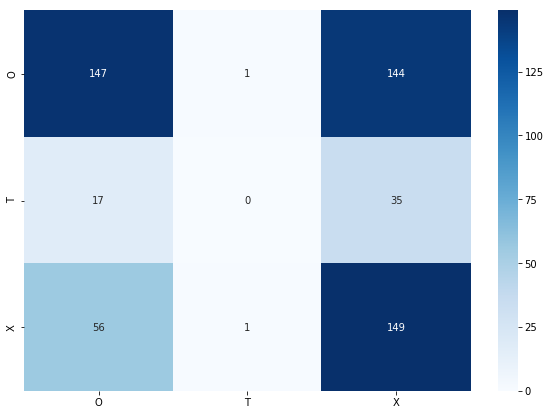

In [52]:
confusion(ea("IRS"))

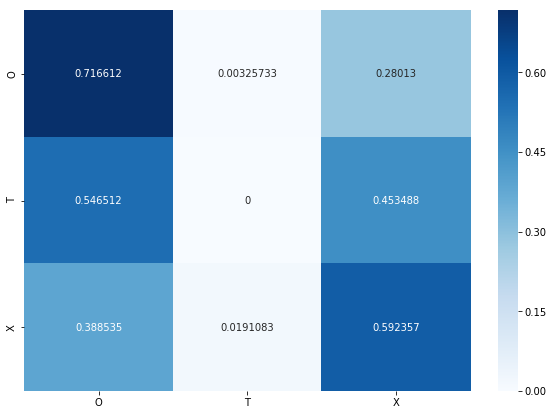

In [36]:
confusion(ea("DCM"))

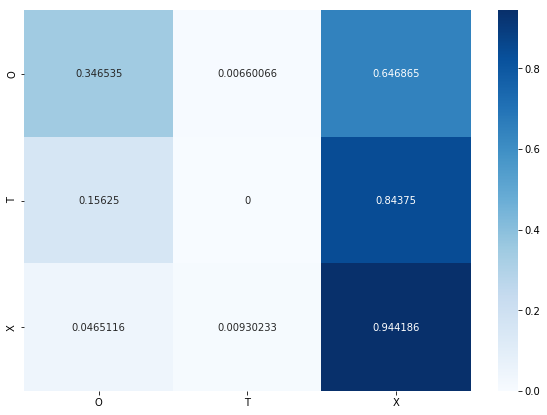

In [37]:
confusion(ea("DIT"))

In [86]:
import pandas as pd

In [87]:
tmp = pd.read_pickle("./data/vecs.pickle")
tmp2 = pd.DataFrame(tmp['system'][:-1])
tmp2.columns = ['system-1']
tmp2.loc[-1] = [[]]
tmp2.index = tmp2.index + 1
tmp2 = tmp2.sort_index()
for i in range(0,len(tmp2),11):
    tmp2['system-1'][i] = np.array([])
df = pd.concat([tmp,tmp2],axis=1)

In [246]:
from preprocess_chainer import mk_minibatch

ImportError: cannot import name 'mk_minibatch'

In [55]:
import json
import glob

In [71]:
fps_cnn = glob.glob("./result_conv_attn/DCM/*")
datas_cnn = sorted([json.load(open(fp)) for fp in fps_cnn],key=lambda x:x["dialogue-id"])

In [69]:
fps_rnn = glob.glob("./result_nomoto/DCM/*")
datas_rnn = sorted([json.load(open(fp)) for fp in fps_rnn],key=lambda x:x["dialogue-id"])

In [82]:
cnn_probs = []
rnn_probs = []
for cnn,rnn in zip(datas_cnn,datas_rnn):
    for turn_cnn,turn_rnn in zip(cnn['turns'],rnn['turns']):
        annt_cnn = turn_cnn['labels'][0]
        annt_rnn = turn_rnn['labels'][0]
        cnn_probs.append((annt_cnn['prob-O'],annt_cnn['prob-T'],annt_cnn['prob-X']))
        rnn_probs.append((annt_rnn['prob-O'],annt_rnn['prob-T'],annt_rnn['prob-X']))

In [85]:
cnn_probs = np.array(cnn_probs)

In [86]:
rnn_probs = np.array(rnn_probs)

In [92]:
def mse(x,y):
    return np.average(np.square(x-y),axis=0)

In [141]:
np.argmax(rnn_probs,axis=1)

array([0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2,
       0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0,
       2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2,
       2, 0,

In [172]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(n_values=3)
oh_rnn = encoder.fit_transform(np.argmax(rnn_probs,axis=1).reshape(1,-1).transpose()).toarray()
oh_cnn = encoder.fit_transform(np.argmax(cnn_probs,axis=1).reshape(1,-1).transpose()).toarray()


In [175]:
mse(oh_rnn,oh_cnn)

array([ 0.19090909,  0.00181818,  0.18909091])

In [196]:
from sklearn.metrics import accuracy_score

ImportError: cannot import name 'accuracy'

In [198]:
accuracy_score(np.argmax(rnn_probs,axis=1),np.argmax(cnn_probs,axis=1))

0.80909090909090908

In [186]:
np.argmax(cnn_probs,axis=1)

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 0,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2,
       2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 0,